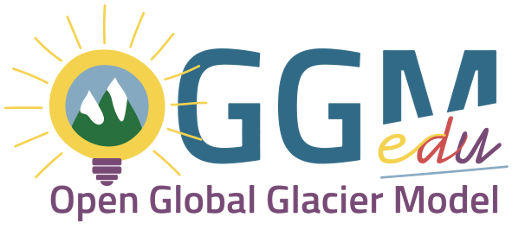

# ELA perturbations and Glacier advance and retreat

Goals of this notebook:

- understand the concept of the equilibrium line altitude (ELA)
- understand the influence of glacier mass balance on the ELA
- estimate how much of a perturbation to mass balance shifts the ELA
- be able to explain glacier advance and retreat in response to a change in the ELA

In [1]:
import oggm
from oggm import cfg
import oggm_edu as edu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from IPython.display import Image

In [2]:
# set default font size in plots
plt.rc('font', size=14)

## Equilibrium line altitude

Recall the definition of glacier mass balance,

$$\dot{m} = \text{accumulation} - \text{ablation}.$$

The rates of accumulation and ablation processes, summed over the glacier and over time, determine the *glacier mass balance* $\dot{m}$, the change in total mass of snow and ice. Since accumulation and ablation generally vary with height, also the glacier mass balance is a function of elevation,

$$\dot{m}(z) = \text{accumulation}(z) - \text{ablation}(z).$$

The altitude where $\dot{m}(z) = 0$ is called the *equilibrium line altitude*, short ELA. Hence, the ELA is the altitude where accumulation processes and ablation processes balance each other - in theory. However, in reality the ELA does not exactly exist and can only be approximated.

In the introduction on the OGGM-Edu [website](http://edu.oggm.org/en/latest/glacier_basics.html), the ELA of a glacier in equilibrium is shown:

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_07.png" width="60%">

## Glacier advance and retreat with OGGM

In [78]:
cfg.initialize_minimal()

2021-02-17 18:50:41: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-17 18:50:41: oggm.cfg: Multiprocessing switched OFF according to the ENV variable OGGM_USE_MULTIPROCESSING
2021-02-17 18:50:41: oggm.cfg: Multiprocessing: using slurm allocated processors (N=1)


First, as always, we define a linear bedrock profile:

In [79]:
# define horizontal resolution of the model:
# nx: number of grid points
# map_dx: grid point spacing in meters
nx = 200
map_dx = 200

In [5]:
# define glacier top and bottom altitudes in meters
top = 5000 
bottom = 0

In [6]:
# create a linear bedrock profile from top to bottom
bed_h, surface_h = edu.define_linear_bed(top, bottom, nx)

In [7]:
# calculate the distance from the top to the bottom of the glacier in km
distance_along_glacier = edu.distance_along_glacier(nx, map_dx)

Then we define the bedrock shape, the glacier width and the mass balance model.

In [80]:
# glacier width at the top of the accumulation area: m
ACCW = 1000

In [81]:
# glacier width at the equilibrium line altitude: m
ELAW = 500

In [82]:
# fraction of vertical grid points occupied by accumulation area
NZ = 1 / 3

In [83]:
# mass balance gradient with respect to elevation in mm w.e. m^-1 yr^-1
mb_grad = 7

Note that `mb_grad` is related to $\partial b_w/\partial z$ from our theoretical work. `mb_grad` is the gradient of total mass balance $mb = b_s - b_w$, so the $\partial b_w/\partial z$ is only part of it's change with altitude.  Note that we were working with units of kg m^-3 yr^-1 actually pretty similar units if you assume the density of water is 1000 kg m^-3).

Finally, we let the glacier evolve according to the equations of motion for ice (which we'll discuss later on) until reaching an equilibrium state. To speed this part up, use the helper function provided in the oggm_edu package:

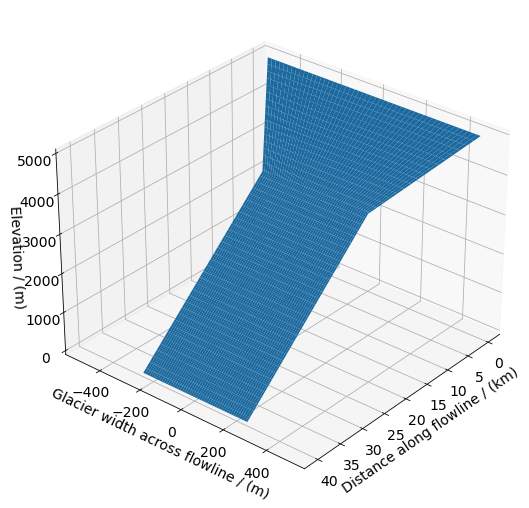

In [84]:
# initialize the model glacier with a linear mass balance profile
model = edu.linear_mb_equilibrium(bed_h, surface_h, ACCW, ELAW, NZ, mb_grad, nx, map_dx)

In [85]:
# the glacier surface in equilibrium
initial = model.fls[-1].surface_h

In [86]:
# the glacier width along the flowline
mwidths = model.fls[-1].widths

In [87]:
# the equilibrium line altitude is determined by NZ above
ela = model.mb_model.get_ela()

Now, we use a linear accumulation and ablation function from the oggm-edu package which constructs profiles that ensure accumulation is zero at the glacier terminus with a specified ELA (thus it's significant that the accumulation profile is defined first and then used to define the ablation profile):

In [16]:
# accumulation and ablation balance each other
acc, acc_0 = edu.linear_accumulation(mb_grad, ela, initial, bed_h, mwidths)
abl, abl_0 = edu.linear_ablation(mb_grad, ela, initial, bed_h, mwidths, acc_0)

``acc_0`` and ``abl_0`` are the accumulation and the ablation at the ELA, respectively - by construction, they should be equal:

In [17]:
print('Mass balance at the ELA: {:.2f} m w.e. yr^-1'.format(float(acc_0 - abl_0)))

Mass balance at the ELA: 0.00 m w.e. yr^-1


Now, we can define the glacier surface after accumulation and ablation, respectively.

In [18]:
# accumulation and ablation surfaces
acc_sfc = initial + acc
abl_sfc = initial + abl

The mass balance is then just the sum of accumulation and ablation:

In [19]:
# net mass balance m w.e yr^-1
mb_we = acc + abl

Near the terminus ablation may totally remove the ice, hence, we need to correct "negative" ice thickness to the glacier bed:

In [20]:
# mass balance surface corrected to the bed where ice thickness is negative
mb_sfc = edu.correct_to_bed(bed_h, initial + mb_we)

Now, let's plot the mass balance by elevation. And confirm that the ELA is where the accumulation and ablation are equal, and therefore the net mass balance is zero.

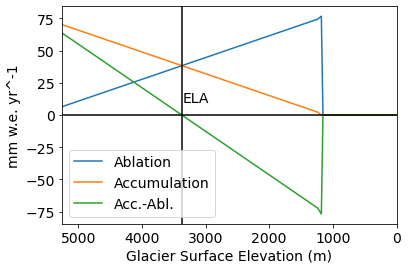

In [88]:
plt.plot(mb_sfc, -abl, label='Ablation')
plt.plot(mb_sfc, acc, label='Accumulation')
plt.plot(mb_sfc, mb_we, label='Acc.-Abl.')
plt.xlim([mb_sfc.max(), mb_sfc.min()])
plt.axhline(0, c='k'); plt.axvline(ela, c='k'); plt.text(ela,10,'ELA');
plt.xlabel('Glacier Surface Elevation (m)'); plt.ylabel('mm w.e. yr^-1')
plt.legend()

**1. Sanity Check** We imposed a constant gradient (i.e., slope) of the total mass balance (accumulation minus ablation) with respect to distance (`mb_grad=7`), so why aren't the curves above straight lines? (Hint: is the glacier surface area the same at each altitude? What is the significance of this?) Play with the values of `ACCW` and `ELAW` to get a feel for this, and to see when our numerical model breaks. Then set `ACCW` to 500.1 and `ELAW` to 500 to simplify the following analysis.

The next figure shows the glacier surface after applying the net mass balance.

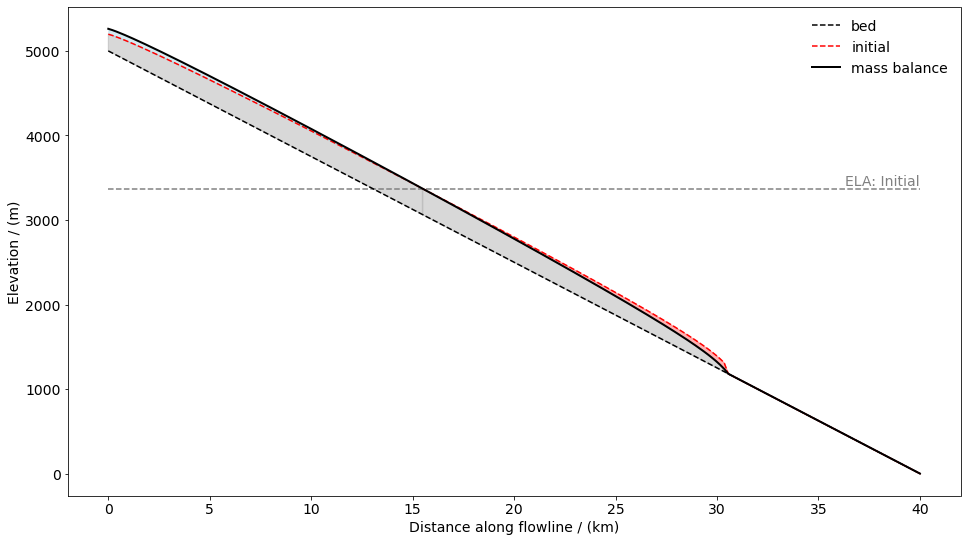

In [22]:
# plot the model glacier
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [mb_sfc], ['mass balance'], ela=[ela], plot_ela=True)

Now we have set the scene to model glacier advance and retreat.

## Advance

More accumulation and/or less ablation leads to a decrease of the ELA and therefore to an increase of the accumulation area and a decrease of the ablation area, as shown in this graph:

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_08.png" width="60%">

To simulate a glacier advance, we will use the same glacier as before, but move the ELA downglacier:

In [54]:
# number of vertical grid points the ELA is shifted downglacier
downglacier = 10

In [55]:
# run the model until the glacier reaches an equilibrium state with its decreased ELA
advance = edu.linear_mb_equilibrium(bed_h, surface_h, ACCW, ELAW, NZ, mb_grad, nx, map_dx, idx=downglacier, advance=True, plot=False)

In [56]:
# decreased ELA
ela_adv = advance.mb_model.get_ela()

In [57]:
print(*['{} ELA: {:.2f} m'.format(s, e) for s, e in zip(['Initial', 'Advance'], [ela, ela_adv])], sep='\n')

Initial ELA: 3366.83 m
Advance ELA: 3115.58 m


**2. Question:** We had the expression for the perturbation of the net melt at the ELA ($\delta b_w$) associated with a shifting of the ELA $\delta z$:
$$\delta b_w = \left(\frac{T}{L}\gamma\frac{\partial T_a}{\partial z} - \frac{\partial b_w}{\partial z}\right)\delta z.$$
Can you predict what the change in the melt rate is that cause this downglacier shift of the ELA? (Note: this is an isothermal glacier, so $\frac{\partial T_a}{\partial z}\equiv0$). 

*Note:* To convert between the ``mb_grad=7`` to $\frac{\partial b_w}{\partial z}$ needs multiplying by 0.0025 (which is the dimensionless half-width of the glacier $\frac{1}{2}$``ACCW`` times a unit factor 1e-3. If you have a widening accumulation area, you need to account for the widening in the $\frac{\partial b_w}{\partial z}$.

Write your estimate here:

Now, we can again calculate linear accumulation, ablation and mass balance profiles, but using the decreased ELA:

In [58]:
# accumulation and ablation balance at the decreased ELA
acc_adv, acc_0_adv = edu.linear_accumulation(mb_grad, ela_adv, initial, bed_h, mwidths)
abl_adv, abl_0_adv = edu.linear_ablation(mb_grad, ela_adv, initial, bed_h, mwidths, acc_0_adv)

The change in mass lost at the ELA associated with this shift in the ELA is

In [59]:
print('Shift in mass lost at ELA: {:.2f} mm w.e. yr^-1'.format(abl_0_adv[0] - abl_0[0]))

Shift in mass lost at ELA: -4.44 mm w.e. yr^-1


**3. Question:** How right was your prediction? What do you think accounts for the difference?

In [60]:
mb_grad * 0.0025 * (ela - ela_adv) 

4.3969849246231165

In [61]:
# net mass balance m w.e yr^-1
mb_adv = acc_adv + abl_adv

In [62]:
# mass balance surface corrected to the bed where ice thickness is negative
mb_sfc_adv = edu.correct_to_bed(bed_h, initial + mb_adv)

Now we can see what happened to produce such a shift (from the solid lines initially to the perturbed, dashed lines):

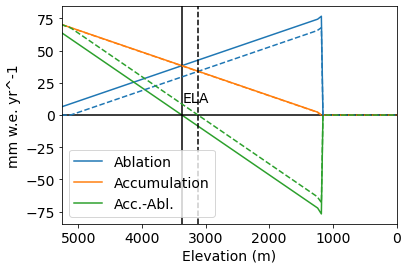

In [63]:
plt.plot(mb_sfc, -abl, label='Ablation')
plt.plot(mb_sfc, acc, label='Accumulation')
plt.plot(mb_sfc, mb_we, label='Acc.-Abl.')
plt.axhline(0, c='k'), plt.axvline(ela, c='k'); plt.text(ela,10,'ELA');

# Reset colors for plot
plt.gca().set_prop_cycle(None)
plt.plot(mb_sfc_adv, -abl_adv, ls='--')
plt.plot(mb_sfc_adv, acc_adv, ls='--')
plt.plot(mb_sfc_adv, mb_adv, ls='--')
plt.axvline(ela_adv, c='k', ls='--');

plt.xlim([mb_sfc.max(), mb_sfc.min()])
plt.xlabel('Elevation (m)'); plt.ylabel('mm w.e. yr^-1')
plt.legend()

An overall decrease in the ablation (accumulation has stayed the same) means the location where accumulation and ablation meet has shifted to a lower elevation (rightward).

The relative increase in the accumulation area leads to a net mass gain compared to the former glacier extent. As discussed in the [accumulation and ablation notebook](accumulation_and_ablation.ipynb), mass is transported downglacier by a gravity driven ice flow obeying conservation of mass

$$\frac{\partial H}{\partial t} = \dot{m} - \nabla \cdot \vec{q}.$$

Therefore, a decrease in the ELA and the resulting net mass gain will lead to a glacier advance as a result of an increased ice flow $\vec{q}$, as indicated as thick arrow in this graph:

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_09.png" width="60%">

We can verify this by plotting the glacier surface after the decrease in the ELA and comparing it to the former glacier surface:

In [64]:
# the glacier surface in equilibrium with the decreased ELA
advance_s = advance.fls[-1].surface_h

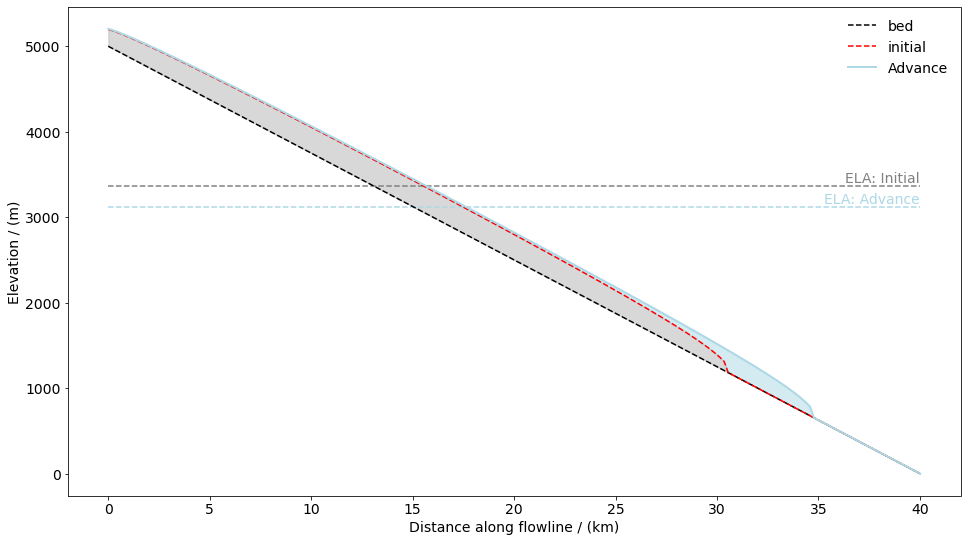

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [advance_s], ['Advance'], ela=[ela, ela_adv], plot_ela=True)

As expected, the glacier advanced downslope.

## Retreat

Analogously, less accumulation and/or more ablation leads to an increase in the ELA and thus to an increase in the ablation area.

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_10.png" width="60%">

To simulate a glacier retreat, we will again use the same glacier, but this time move the ELA upglacier.

In [66]:
# number of vertical grid points the ELA is shifted upglacier
upglacier = 10

In [67]:
# run the model until the glacier reaches an equilibrium state with its decreased ELA
retreat = edu.linear_mb_equilibrium(bed_h, surface_h, ACCW, ELAW, NZ, mb_grad, nx, map_dx, idx=upglacier, retreat=True, plot=False)

In [68]:
# decreased ELA
ela_rtr = retreat.mb_model.get_ela()

In [69]:
print(*['{} ELA: {:.2f} m'.format(s, e) for s, e in zip(['Initial', 'Retreat'], [ela, ela_rtr])], sep='\n')

Initial ELA: 3366.83 m
Retreat ELA: 3592.96 m


**4. Question:** Again write your estimate here

Now, we can again calculate linear accumulation, ablation and mass balance profiles, but using the increased ELA:

In [70]:
# accumulation and ablation balance at the decreased ELA
acc_rtr, acc_0_rtr = edu.linear_accumulation(mb_grad, ela_rtr, initial, bed_h, mwidths)
abl_rtr, abl_0_rtr = edu.linear_ablation(mb_grad, ela_rtr, initial, bed_h, mwidths, acc_0_rtr)

In [72]:
print('Shift in accumulation at ELA: {:.2f} mm w.e. yr^-1'.format(acc_0_rtr[0] - acc_0[0]))

Shift in accumulation at ELA: 3.97 mm w.e. yr^-1


In [73]:
# net mass balance m w.e yr^-1
mb_rtr = acc_rtr + abl_rtr

In [74]:
# mass balance surface corrected to the bed where ice thickness is negative
mb_sfc_rtr = edu.correct_to_bed(bed_h, initial + mb_rtr)

The increase in the ablation area leads to a net mass loss compared to the former glacier extent. Therefore, an increase in the ELA will lead to a glacier retreat as a result of a decreased ice flow $\vec{q}$, as indicated as thin arrow in this graph:

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_11.png" width="60%">

We can verify this by plotting the glacier surface after the increase in the ELA and comparing it to the former glacier surface:

In [75]:
# the glacier surface in equilibrium with the decreased ELA
retreat_s = retreat.fls[-1].surface_h

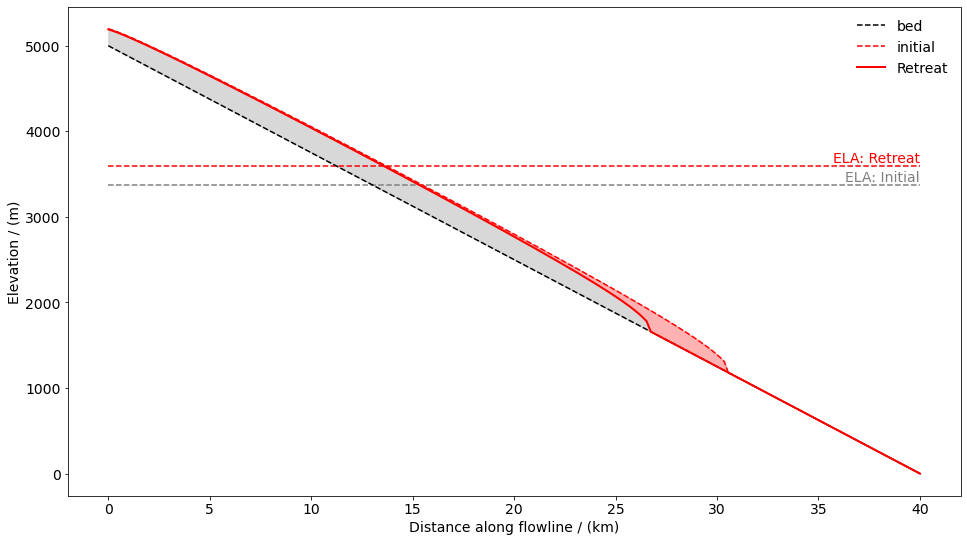

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [retreat_s], ['Retreat'], ela=[ela, ela_rtr], plot_ela=True)

As expected, the glacier retreats upslope.

## Take home points

- The equilibrium line altitude (ELA) is the altitude on a glacier where accumulation and ablation balance, meaning $\dot{m}(z) = 0$ at $z=$ ELA
- A decrease in the ELA leads to:
    1. an increase in the accumulation
    2. a decrease in the ablation area
    3. a net mass gain resulting in an increased ice flux downglacier
    4. a glacier advance
- An increase in the ELA leads to:
    1. a decrease in the accumulation area
    2. an increase in the ablation area
    3. a net mass loss resulting in a decreased ice flux downglacier
    4. a glacier retreat

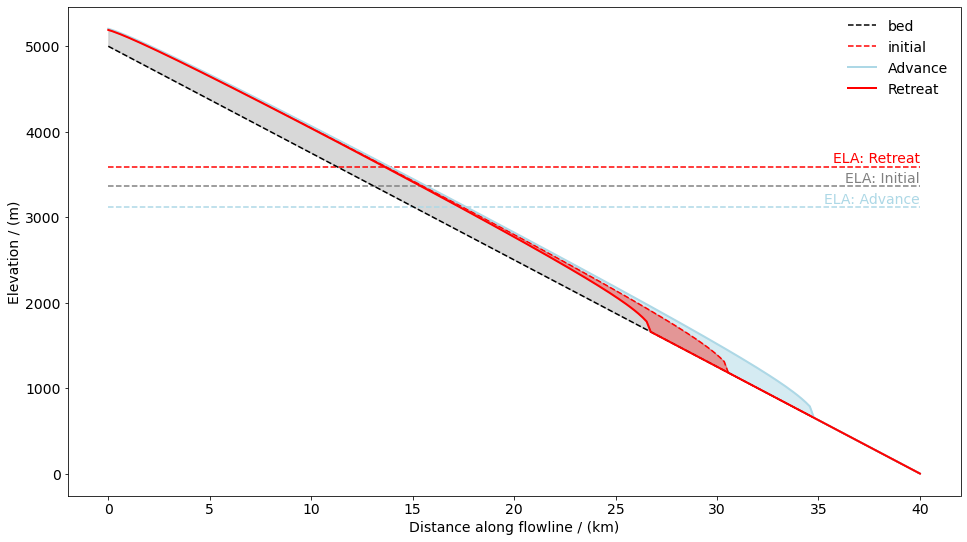

In [77]:
# or if you are a visual type learner
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [advance_s, retreat_s], ['Advance', 'Retreat'], ela=[ela, ela_adv, ela_rtr], plot_ela=True)

Now it's time to explore a little bit more. You may choose either
1. Change the width of the glacier (``ACCW`` and ``ELAW``, always keeping the first a teeny bit bigger than the second - else it breaks) and the mass balance gradient ``mb_grad`` and investigate how the glacier and the size of the perturbations change. Record your experiments and reflect on them.
2. Mess with the accumulation zone area by changing ``ACCW`` back to 1000, see how your estimates using our basic analysis goes off (because we are missing the part of the derivative that includes the widening glacier). Then see if you can reduce the error a little bit by making the perturbation smaller (``downglacier`` and ``upglacier`` were 10 so far. Make them smaller and see what the error does) Can you figure out how to include the component of the derivative we omitted and whether that makes the estimate of the perturbation fit better?